In [1]:
import sys
sys.path.append("..")

import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from ipywidgets import interact

# from conc_obj import EEGData
from obj.eeg_data import EEGData
from utils.plt import plot_psd, plot_montage
from utils.ica import plot_ica_comp
from utils.freq_perturbation import frequency_perturbation

# MNE imports
import mne
from mne.io.edf import read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from csp.CSPObj_cheat import CSP as FBCSP

from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.exceptions import ConvergenceWarning

from sklearn.model_selection import cross_val_score, LeaveOneGroupOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import LearningCurveDisplay, learning_curve
from sklearn.covariance import LedoitWolf

import lightgbm as lgb
import json
import warnings


***Macros***

>General use macros, importing JSON files to use as the configuration files

In [2]:
script_path = Path().resolve()
main_folder = (script_path / "../").resolve()
proj_folder = (script_path / "../../").resolve()

JSON_MAIN_PATH = main_folder / "config/config_main.json"
JSON_CSP_PATH = main_folder / "config/config_csp.json"
JSON_GRID_PATH = main_folder / "config/config_grid.json"
EVENTS_PATH = main_folder / "config/events.json"

with open(JSON_MAIN_PATH, "r") as f:
    config_main = json.load(f)

with open(JSON_CSP_PATH, "r") as f:
    config_csp = json.load(f)
    
with open(JSON_GRID_PATH, "r") as f:
    json_grid = json.load(f)

VERBOSE = config_main['verbose'].lower() == 'true'

L_FREQ = config_main['l_freq']
H_FREQ = config_main['h_freq']

N_SUBJECTS = config_main["n_subjects"]
N_COMPONENTS_ICA = config_main["n_components_ica"]
N_COMPONENTS_CSP = config_csp["n_components"]
N_COMPONENTS_PCA = N_COMPONENTS_CSP

"""
T0 corresponds to rest
T1 corresponds to onset of motion (real or imagined) of
the left fist (in runs 3, 4, 7, 8, 11, and 12)
both fists (in runs 5, 6, 9, 10, 13, and 14)
T2 corresponds to onset of motion (real or imagined) of
the right fist (in runs 3, 4, 7, 8, 11, and 12)
both feet (in runs 5, 6, 9, 10, 13, and 14)
"""


'\nT0 corresponds to rest\nT1 corresponds to onset of motion (real or imagined) of\nthe left fist (in runs 3, 4, 7, 8, 11, and 12)\nboth fists (in runs 5, 6, 9, 10, 13, and 14)\nT2 corresponds to onset of motion (real or imagined) of\nthe right fist (in runs 3, 4, 7, 8, 11, and 12)\nboth feet (in runs 5, 6, 9, 10, 13, and 14)\n'

In [3]:
mne.set_log_level("ERROR")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='mne'),

(None,)

***Initialization of EEG object***

>***(If the files are not locally stored, it will download them to the user system automatically)***

>***Use of functions like .filter_data() also is obligatory if there is no data stored locally***

In [4]:
eeg_obj = EEGData(config_main, config_csp, proj_folder, verbose=VERBOSE)

#* Filters data and plots PSD to see differences
# eeg_obj.filter_data()

# eeg_obj.plot_psd_ba_filt(config_csp["freq_bands__02"])

# eeg_obj.plot_psd(verbose=VERBOSE)


<Raw | sample_mmi_h_raw.fif, 64 x 5921920 (37012.0 s), ~2.82 GiB, data loaded> <Raw | sample_mmi_hf_raw.fif, 64 x 5921600 (37010.0 s), ~2.82 GiB, data loaded>
<Raw | sample_mmi_h_filt_raw.fif, 64 x 5921920 (37012.0 s), ~2.82 GiB, data loaded> <Raw | sample_mmi_hf_filt_raw.fif, 64 x 5921600 (37010.0 s), ~2.82 GiB, data loaded>
<Raw | sample_mmi_h_clean_raw.fif, 64 x 5921920 (37012.0 s), ~2.82 GiB, data loaded> <Raw | sample_mmi_hf_clean_raw.fif, 64 x 5921600 (37010.0 s), ~2.82 GiB, data loaded>


***Prediction - Loading testing data & ML models***

>***If we don't want to train our model and want to make predictions or see any metric right away, we can load the data and call the methods right away.***

>***Take into account that in order to change the events or any other parameter in the tools/methods loaded, you will have to train and save the entire model/data again!***

In [5]:

# X_test, y_test = eeg_obj.load_models()
# eeg_obj.pred(X_test, y_test)

**Basic information and montage plotting in 2D & 3D**
> ***The channel names can also be printed***

In [6]:

#* Plots different montages in 2D & 3D
# data = eeg_obj.get_raw_h()
# ch_names = data.info["ch_names"] 
# plot_montage(eeg_obj.montage, ch_names)

**ICA(Independent Component Analysys)**
> ***The number of components that ICA will try to sort out can be changed, it is advised to use values in the range [15-45]***

> ***Ocular artifacts are also removed, since they don't contribute to the muscular movement on this evaluation***

> ***The components can also be plotted and ocular artifacts, EOG, will be clearly visible***

In [7]:

#* Computes ICA components
# eeg_obj.decomp_ica(n_components=N_COMPONENTS_ICA, plt_show=True, verbose=VERBOSE)

#* Plot components of ICA
# plot_ica_comp(proj_folder / config_main["path_ica_h"])


**Specify events & create Epochs**
> ***The events used along with the JSON configuration will be crucial for the ML algorimths to work properly***


In [8]:
data_h, data_hf = eeg_obj.get_clean()
events_h, events_hf = eeg_obj.get_events()

event_l = config_csp["ev_blist_one"]
groupeve_dict = config_csp["event_dict_h"]

epochs, subjects = eeg_obj.crt_epochs(data_h, events_h, event_l, "hands", verbose=VERBOSE)

epochs_data = epochs.get_data()
features = []
for data in epochs_data:
	features.append(frequency_perturbation(data, 0.5, config_csp["frequency_sample"]))
epochs_data = np.array(features)

labels = epochs.events[:, -1] - 1

Event dict. :  {'do/left_hand': 1, 'do/right_hand': 2}


In [9]:
# data_h.plot(events=events_h, event_id=event_dict, duration=10, scalings='auto')

***CSP - Common Spatial Pattern(s)***

>Separates multivariate signals into additive components which have maximum differences in variance between two windows.

>Specially used on MEG & EEG datasets for motor imagery decoding.

In [10]:
N_COMPONENTS_CSP = config_csp["n_components"]
features = epochs_data
freq_bands = config_csp["freq_bands__02"]

#* Verify any shape
print("Shape of features:", features.shape)

Shape of features: (2250, 64, 481)


In [11]:

#* Divide the data into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (1800, 64, 481)
X_test shape: (450, 64, 481)


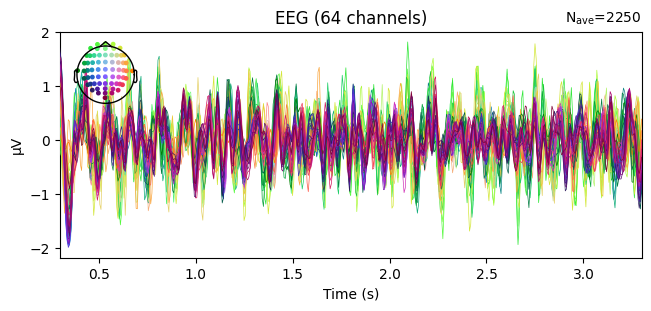

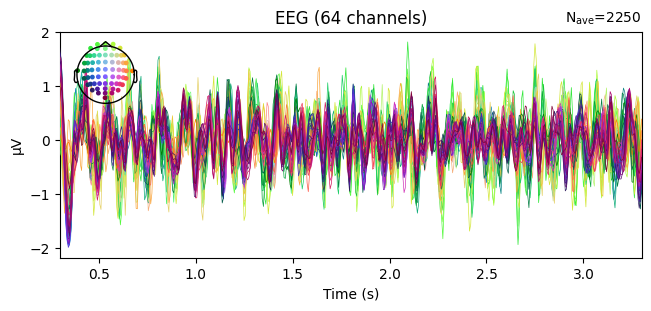

In [12]:
epochs.average().plot()

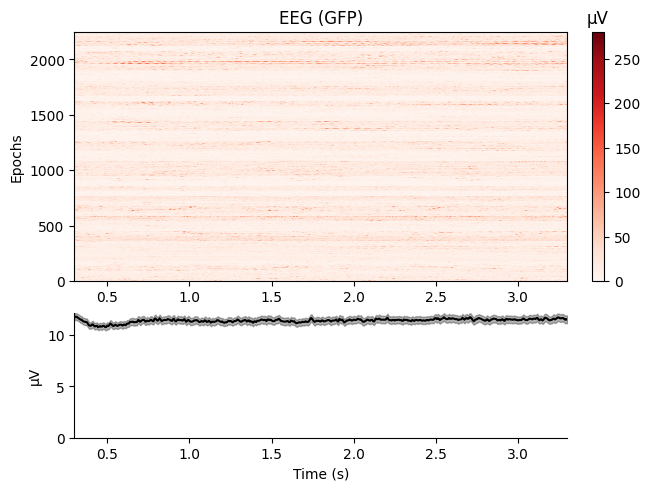

[<Figure size 640x480 with 3 Axes>]

In [13]:
epochs.plot_image(picks='eeg')

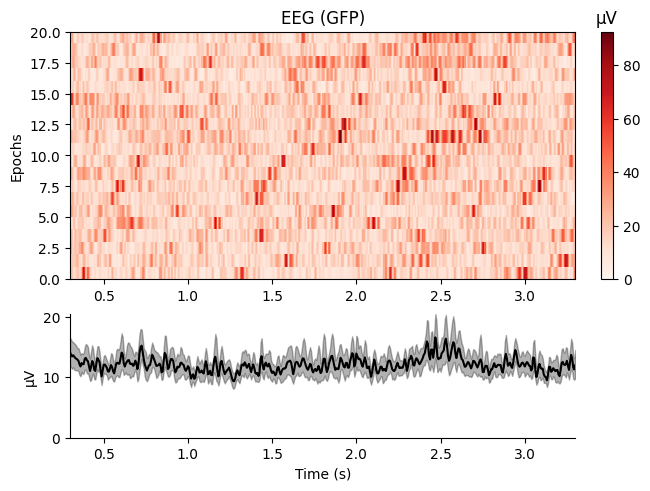

[<Figure size 640x480 with 3 Axes>]

In [14]:
epochs[:20].plot_image(picks='eeg')

***Pipeline***

>The dimensionality reduction tools, classifications algorimths and signal processing (CSP) are included.

>The default values/functions have been proved to be good over tests.

In [15]:
print(X_train.shape, y_train.shape)

(1800, 64, 481) (1800,)


In [16]:
svm_clf = SVC(kernel='rbf', C=250, gamma=0.025, probability=True)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500)

pipeline = Pipeline([
    # ('std_before', StandardScaler()),
    ('csp', FBCSP(n_components=config_csp["n_components"], freq_bands=freq_bands, fs=config_csp["frequency_sample"], log=True, norm_trace=False)),

    ('std_after', StandardScaler()),
    ('pca', PCA(n_components=0.99)),
    #* Choose only one of the following classifiers
	# ('lda', LDA())
    # ('svm', SVC(kernel='rbf', C=250, gamma=0.025, probability=True))
	# ('rf', RandomForestClassifier(n_estimators=400, max_depth=50, min_samples_split=25, random_state=42))
	# ('clf', VotingClassifier(estimators=[('svm', svm_clf), ('mlp', mlp_clf)], voting='soft'))
    ('mlp', MLPClassifier(hidden_layer_sizes=[128, 256, 256], max_iter=1000, learning_rate_init=0.001, alpha=0.0005, random_state=42, learning_rate='adaptive'))
    # ('lgb', lgb.LGBMClassifier(lgb__learning_rate=0.2, lgb__max_depth=-1, lgb__n_estimators=500, lgb__num_leaves=50))
])

# Fit the pipeline to the data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('csp',
                 CSP(freq_bands=[[8, 12], [12, 18], [18, 24], [24, 30]],
                     n_components=16)),
                ('std_after', StandardScaler()),
                ('pca', PCA(n_components=0.99)),
                ('mlp',
                 MLPClassifier(alpha=0.0005, hidden_layer_sizes=[128, 256, 256],
                               learning_rate='adaptive', max_iter=1000,
                               random_state=42))])

***GridSearch - Parameter selection***

>Exhaustive search over specified parameter values for an estimator.

>The default values have been tested. Performance varies from event type selection.

In [17]:
from importlib import reload
import utils.grid_search
reload(utils.grid_search)
from utils.grid_search import grid_finder, grid_search

grid, pipepline_grid = grid_finder(json_grid, 'mlp', 'wide')
print(grid)

# params, scores = grid_search(X_train, y_train, pipeline, param_grid)

{'mlp__max_iter': [1000, 2000], 'mlp__hidden_layer_sizes': [[200, 300], [400, 500]]}


In [18]:

# Define a splitting strategy ideal for the data
# cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=False)


***Cross Validation - The reliable tester***

>We feed it the n_splits we chose on the K-folds along with the pipeline.

>It ensures that the training/testing datasets are not mixed & calculates the average score over the K-folds.

In [19]:
# Perform cross-validation
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)

scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1)

print("Train set accuracy:", train_score)
print("<------------------------->")
print("Cross-validation scores:", scores)
print("Mean: ", np.mean(scores))
print("<------------------------->")
print("Test set accuracy(Untouched):", test_score)

Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 0.00079 (2.2e-16 eps * 64 dim * 5.5e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 0.00079 (2.2e-16 eps * 64 dim * 5.5e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 0.00078 (2.2e-16 eps * 64 dim * 5.5e+10  max singular value)
    Using tolerance 0.0008 (2.2e-16 eps * 64 dim * 5.6e+10  max singular value)
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Done.
    

***Feature-Based Classification Comparison***

In [20]:
# Create a new pipeline excluding the last step
pipeline_without_last_step = Pipeline(pipeline.steps[:-1])

# Transform the data using the new pipeline
processed_X_train = pipeline_without_last_step.transform(X_train)
processed_X_test = pipeline_without_last_step.transform(X_test)
print(processed_X_train.shape)

eeg_obj.train_model(processed_X_train, y_train)

eeg_obj.pred(processed_X_test, y_test, n_preds=30, prt_matrix=True)

(1800, 46)
SVC()
[LightGBM] [Info] Number of positive: 894, number of negative: 906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 1800, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496667 -> initscore=-0.013334
[LightGBM] [Info] Start training from score -0.013334
Train Accuracy [ LDA ]: 0.7266666666666667
Train Accuracy [ SVM ]: 0.7611111111111111
Train Accuracy [ RF ]: 1.0
Train Accuracy [ LGBM ]: 1.0
Train Accuracy [ MLP ]: 0.9516666666666667

epoch nb: [prediction] [truth] equal?
epoch 000:	[0]		[1]  False
epoch 001:	[1]		[0]  False
epoch 002:	[1]		[1]  True
epoch 003:	[0]		[0]  True
epoch 004:	[1]		[1]  True
epoch 005:	[1]		[1]  True
epoch 006:	[1]		[1]  True
epoch 007:	[0]		[1]  False
epoch 008:	[0]		[1]  False
epoch 009:	[1]		[0]  False
epoc

/Users/Shared/42/total_persceptive_vortex/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/Shared/42/total_persceptive_vortex/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Saving data locally**
> ***Saving and loading data locally saves time and computational power***

> ***Note that it is also needed to change the configuration at the JSON files to import local files***

In [21]:
#* Saves filtered and concatenated data for faster loading
# eeg_obj.save_type_data(type="raw")
# eeg_obj.save_type_data(type="filtered")
# eeg_obj.save_type_data(type="clean")
# eeg_obj.save_type_data(type="ica")
# eeg_obj.save_type_data(type="events")
# eeg_obj.save_models()
# eeg_obj.save_type_data(type="epochs")